In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = "C:/Users/hosei/Documents/DataSets/GTSRB"
train_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Train/"
test_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Test/"


train_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Train.csv')
test_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Test.csv')

In [3]:
#hyper parametes
num_of_classes = len(os.listdir(train_path))
height = 30
width = 30
channels = 3
n_inputs = height * width * num_of_classes
num_epochs = 2
batch_size = 2
learning_rate = 0.001

In [4]:
num_of_classes

43

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [7]:

# #data Visualation
# folder_names = [os.path.join(train_path, str(i)) for i in random.choices(range(43), k=20)] 
# file_names = [os.path.join(fldr, os.listdir(fldr)[0]) for fldr in folder_names]

# fig, axes = plt.subplots(4, 5, figsize=(12, 8))
# for i, image_path in enumerate(file_names):
#     image = Image.open(image_path)
#     row = i // 5
#     col = i % 5
#     axes[row, col].imshow(image)
#     axes[row, col].axis('off')

# plt.show()

In [8]:
# Transforming the Data ToTensor and Normalize it + resize to 28*28

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((112,112))])

#creating the dataset class
class GTSR_DataSet(Dataset):
    def __init__(self, df, root_dir,transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_path = os.path.join(self.root_dir,self.df.iloc[index,7])  #the column of paths in dataframe is 7
        image = Image.open(image_path)
        y_class = torch.tensor(self.df.iloc[index, 6]) #the column of ClsassId in daraframe is 6
        
        if self.transform:
            image = self.transform(image)
            return (image, y_class)

In [9]:
training_set = GTSR_DataSet(train_df,data_dir,transform=transforms)
test_set = GTSR_DataSet(test_df,data_dir,transform=transforms)

In [10]:
train_loader = DataLoader(dataset = training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=batch_size, shuffle=False)

dataloaders = {'training':train_loader,'testing':test_loader}
dataset_sizes = {'training':len(train_loader.dataset),'testing':len(test_loader.dataset)}
print(dataset_sizes)

{'training': 39209, 'testing': 12630}


In [11]:
#creating the model
class GTRSB_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(GTRSB_Model, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(1024)
        # self.maxpool3 = nn.AdaptiveMaxPool2d(512)
        

        
        self.l1 = nn.Linear(50176,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_size)




    def forward(self,input):
        #training pipeline

        conv = self.conv1(input)
        
        conv = self.conv2(conv)

        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)

        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv5(maxpool)
        conv = self.conv6(conv)
        batchnorm = self.relu(self.batchnorm3(conv))
        maxpool = self.maxpool(batchnorm)
        maxpool = self.maxpool(maxpool)
    

              
        flatten = self.flatten(maxpool)
        
        #Neural Network Featuremap input
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        
    
        return output

In [12]:
input_size = 3*112*112
output_size = 43
model = GTRSB_Model(input_size=input_size, output_size=output_size)
model.cuda()

GTRSB_Model(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_

In [13]:
# model deployment with Adamax Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            n_samples +=labels.shape[0]
            n_correct +=(predictions == labels).sum().item()
        acc = 100.0 * (n_correct / n_samples)
        print(f'epoch {epoch+1} / 10, Adamax accuracy = {acc}')
        

c:\Users\hosei\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch 1 / 2, step 200, loss = 5.230493545532227
epoch 1 / 2, step 400, loss = 3.3327012062072754
epoch 1 / 2, step 600, loss = 3.7672553062438965
epoch 1 / 2, step 800, loss = 3.488649845123291
epoch 1 / 2, step 1000, loss = 2.4566357135772705
epoch 1 / 2, step 1200, loss = 2.343684196472168
epoch 1 / 2, step 1400, loss = 1.2378560304641724
epoch 1 / 2, step 1600, loss = 2.7463269233703613
epoch 1 / 2, step 1800, loss = 2.039952278137207
epoch 1 / 2, step 2000, loss = 1.0540404319763184
epoch 1 / 2, step 2200, loss = 2.972940683364868
epoch 1 / 2, step 2400, loss = 2.432114601135254
epoch 1 / 2, step 2600, loss = 2.734032154083252
epoch 1 / 2, step 2800, loss = 1.531967043876648
epoch 1 / 2, step 3000, loss = 2.855259418487549
epoch 1 / 2, step 3200, loss = 2.323239326477051
epoch 1 / 2, step 3400, loss = 1.5934698581695557
epoch 1 / 2, step 3600, loss = 1.0388134717941284
epoch 1 / 2, step 3800, loss = 2.2671821117401123
epoch 1 / 2, step 4000, loss = 2.2711241245269775
epoch 1 / 2, s

KeyboardInterrupt: 

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.(model.parameters(), lr=learning_rate)

In [ ]:
# # # model deployment with SGD Optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate , momentum=0.9)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, SGD accuracy = {acc}')
        
        

# # print("---------------------------------")


        
        

# # # model deployment with Adam optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, ADAM accuracy = {acc}')
        
        
        

# # print("---------------------------------")


        

# # # model deployment with ASGD Optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, ASGD accuracy = {acc}')
        
        
        

# # print("---------------------------------")




# # # model deployment with Adadelta Optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate , rho=0.9)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, Adadelta accuracy = {acc}')
        
        

# # print("---------------------------------")


# # # model deployment with Adagrad Optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, Adagrad accuracy = {acc}')
        
        

# # print("---------------------------------")

        
        
# # # model deployment with AdamW Optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, AdamW accuracy = {acc}')
        
        

# # print("---------------------------------")


        
        
# # model deployment with Adamax Optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
# for epoch in range(10):
#     for i, (images, labels) in enumerate(train_loader):
#         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
        

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if (i+1) % 200 == 0:
#             print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

#     with torch.no_grad():
#         n_correct = 0
#         n_samples = 0
#         for images, labels in test_loader:
#             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
#             labels = labels.to(device)
#             outputs = model(images)

#             _, predictions = torch.max(outputs, 1)
#             n_samples +=labels.shape[0]
#             n_correct +=(predictions == labels).sum().item()
#         acc = 100.0 * (n_correct / n_samples)
#         print(f'epoch {epoch+1} / 10, Adamax accuracy = {acc}')
        
        

# # print("---------------------------------")        

        
# # # model deployment with NAdam Optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, NAdam accuracy = {acc}')
        
        

# # print("---------------------------------")


        
# # # model deployment with RAdam Optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, RAdam accuracy = {acc}')
        
        
        
# # print("---------------------------------")

        
# # # model deployment with RMSprop Optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, RMSprop accuracy = {acc}')
        


# # print("---------------------------------")

        
        
# # # model deployment with Rprop Optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
# # for epoch in range(10):
# #     for i, (images, labels) in enumerate(train_loader):
# #         # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
# #         images = images.to(device)
# #         labels = labels.to(device)

# #         outputs = model(images)
# #         loss = criterion(outputs, labels)
        
        

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         # if (i+1) % 500 == 0:
# #         #     print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

# #     with torch.no_grad():
# #         n_correct = 0
# #         n_samples = 0
# #         for images, labels in test_loader:
# #             images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
# #             labels = labels.to(device)
# #             outputs = model(images)

# #             _, predictions = torch.max(outputs, 1)
# #             n_samples +=labels.shape[0]
# #             n_correct +=(predictions == labels).sum().item()
# #         acc = 100.0 * (n_correct / n_samples)
# #         print(f'epoch {epoch+1} / 10, Rprop accuracy = {acc}')

c:\Users\hosei\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch 1 / 2, step 200, loss = 4.5721259117126465


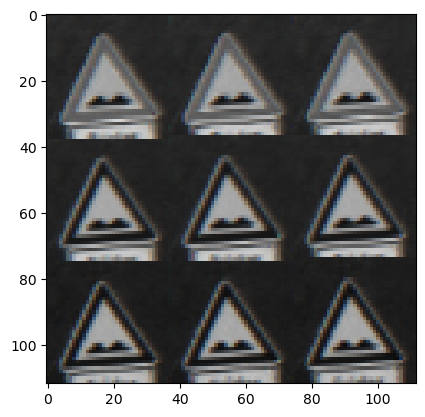

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
image = images[0]
image.shape 

torch.Size([ 112, 112]) # pyplot doesn't like this, so reshape

image = image.reshape(112,-1,3)
plt.imshow(image.numpy())